## Calculate differences
- Calculate differences using different models on the effect of Trauma vs. Sad on hippocampus

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az

# regular GLMs
import pingouin as pg
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [3]:
## Load amygdala database
df = pd.read_csv('TraumavsNeutral_threeSes.csv')
# create a long format for analysis
df_long = pd.melt(df, id_vars=['scr_id','groupIdx'], value_vars=['hippo1','hippo2','hippo3'])
df_long

scr_id  groupIdx variable     value
0    KPE008         1   hippo1  0.464944
1   KPE1223         1   hippo1  0.088564
2   KPE1253         0   hippo1 -0.182786
3   KPE1263         0   hippo1 -0.387857
4   KPE1293         1   hippo1  0.085905
..      ...       ...      ...       ...
73  KPE1561         0   hippo3  0.102486
74  KPE1573         1   hippo3  0.529858
75  KPE1578         0   hippo3  0.049309
76  KPE1587         1   hippo3       NaN
77  KPE1612         0   hippo3  0.205522

[78 rows x 4 columns]

In [4]:
## Start with simple GLM models (using statsmodel)
glm = smf.mixedlm('value ~ variable * groupIdx', data=df_long, groups = df_long.scr_id, 
                 missing='drop')
model1 = glm.fit()
print(model1.summary())

                Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      value   
No. Observations:       73           Method:                  REML    
No. Groups:             26           Scale:                   0.1406  
Min. group size:        2            Log-Likelihood:          -39.1486
Max. group size:        3            Converged:               Yes     
Mean group size:        2.8                                           
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   -0.031    0.108 -0.290 0.772 -0.243  0.180
variable[T.hippo2]           0.217    0.150  1.443 0.149 -0.078  0.512
variable[T.hippo3]           0.041    0.159  0.258 0.796 -0.270  0.352
groupIdx                     0.060    0.153  0.390 0.696 -0.239  0.359
variable[T.hippo2]:grou

In [5]:
# mixed anova
aov = pg.mixed_anova(data=df_long, dv='value', between='groupIdx', within='variable',
                     subject='scr_id', correction=False, effsize="np2")
pg.print_table(aov)


ANOVA SUMMARY

Source          SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------  -----  -----  -----  -----  -----  -------  -----  -------
groupIdx     0.447      1     19  0.447  2.311    0.145  0.108  nan
variable     0.121      2     38  0.061  0.419    0.661  0.022    0.988
Interaction  0.532      2     38  0.266  1.836    0.173  0.088  nan



## Build a Bayesian model
- Here we would model each subject under each group

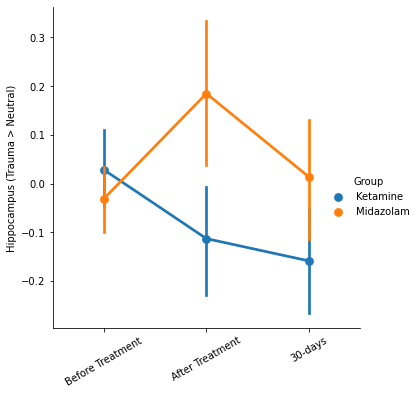

In [6]:
g = sns.catplot(y='value',x='variable', hue='groupIdx', data=df_long, kind='point', ci=68,
               hue_order=[1,0])
g.set_xlabels("")
g.set_xticklabels(
    labels=["Before Treatment", "After Treatment", "30-days"], rotation=30)

g.set_ylabels("Hippocampus (Trauma > Neutral)")
g._legend.set_title("Group")
new_labels = ['Ketamine', 'Midazolam']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
g.savefig('hippo_pointGraph.png', dpi=300, bbox_inches='tight')

In [7]:
#df[['hippo1','hippo2','hippo3', 'hippo4','groupIdx']].groupby('groupIdx').describe()
df_long.groupby(['groupIdx','variable']).describe()

value                                                    \
                  count      mean       std       min       25%       50%   
groupIdx variable                                                           
0        hippo1    13.0 -0.031305  0.264194 -0.387857 -0.202330  0.006992   
         hippo2    12.0  0.184824  0.531310 -0.961320 -0.058206  0.131446   
         hippo3    10.0  0.013557  0.421124 -0.686757 -0.216576  0.119983   
1        hippo1    13.0  0.028279  0.295527 -0.564142 -0.080083  0.085905   
         hippo2    13.0 -0.113132  0.401257 -0.981734 -0.310219 -0.103985   
         hippo3    12.0 -0.158917  0.384423 -1.113694 -0.293271 -0.103110   

                                       
                        75%       max  
groupIdx variable                      
0        hippo1    0.227546  0.338373  
         hippo2    0.439066  1.051994  
         hippo3    0.306844  0.474120  
1        hippo1    0.225363  0.464944  
         hippo2    0.114281  0.500000  
         hippo3    0.027721  0.529858

In [8]:
# take indexes for building the model
df_long['scr_id'] = df_long.scr_id.astype('category')
sub_idx = df_long.scr_id.cat.codes.values # get county category index values (613 x 1) vec with nums [0-7]
print(sub_idx)
n_subs = len(np.unique(df_long.scr_id))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
df_long.variable = pd.Categorical(df_long.variable, 
                    categories=['hippo1','hippo2','hippo3'])
timeIDX = df_long.variable.cat.codes.values
print(timeIDX)
df_long['time'] = timeIDX


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21
 22 23 24 25  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 20 21 22 23 24 25]
26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2]


In [9]:
## Run similar model but without hyperpriors
# now we build a model - modeling the score of each group on each time point
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sd=0.1, shape=n_subs)
       
    b = pm.Normal('b', mu=0, sd=0.1, shape=4)

    
    bMed = pm.Normal('bMed', mu=0, sd=0.1, shape=1) #
  
    # Model error
    eps = pm.HalfCauchy('eps', 1)

    y_hat = a[sub_idx] + b[timeIDX] + bMed*df_long.groupIdx 

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=df_long.value)
    
    trace = pm.sample(10000, target_accept=0.9, return_inferencedata=True, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, bMed, b, a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 19 seconds.


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'bMed'}>,
        <AxesSubplot:title={'center':'bMed'}>],
       [<AxesSubplot:title={'center':'likelihood_missing'}>,
        <AxesSubplot:title={'center':'likelihood_missing'}>],
       [<AxesSubplot:title={'center':'eps'}>,
        <AxesSubplot:title={'center':'eps'}>]], dtype=object)

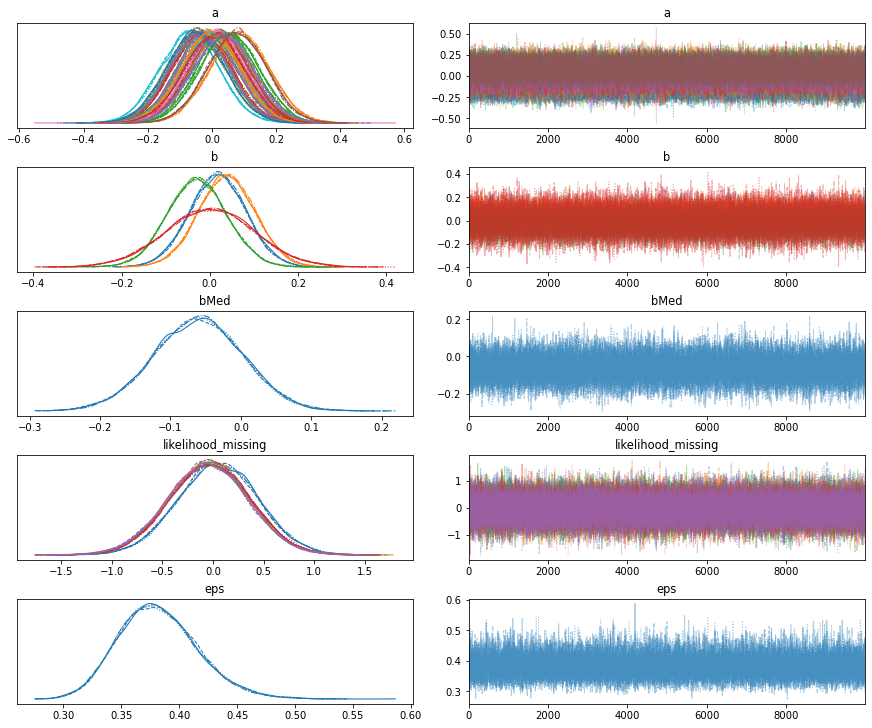

In [10]:
az.plot_trace(trace)

In [11]:
az.summary(trace, hdi_prob=.9)

mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
a[0]                   0.031  0.091  -0.117    0.185      0.000    0.000   
a[1]                   0.028  0.091  -0.116    0.185      0.000    0.000   
a[2]                  -0.018  0.093  -0.169    0.135      0.000    0.000   
a[3]                   0.020  0.092  -0.134    0.169      0.000    0.000   
a[4]                  -0.015  0.091  -0.165    0.135      0.000    0.000   
a[5]                  -0.035  0.092  -0.189    0.112      0.000    0.000   
a[6]                   0.007  0.092  -0.140    0.160      0.000    0.000   
a[7]                  -0.008  0.091  -0.154    0.143      0.000    0.000   
a[8]                  -0.051  0.092  -0.203    0.099      0.000    0.000   
a[9]                  -0.070  0.092  -0.221    0.079      0.000    0.000   
a[10]                 -0.040  0.092  -0.188    0.113      0.000    0.000   
a[11]                  0.086  0.093  -0.069    0.235      0.000    0.000   
a[12]                  0.044  0.091  -0.103    0.198      0.000    0.000   
a[13]                 -0.031  0.092  -0.184    0.117      0.000    0.000   
a[14]                 -0.039  0.092  -0.188    0.115      0.000    0.000   
a[15]                  0.023  0.091  -0.126    0.174      0.000    0.000   
a[16]                  0.015  0.091  -0.133    0.164      0.000    0.000   
a[17]                 -0.040  0.091  -0.190    0.110      0.000    0.000   
a[18]                 -0.003  0.093  -0.156    0.151      0.000    0.000   
a[19]                  0.001  0.094  -0.150    0.158      0.000    0.000   
a[20]                 -0.051  0.091  -0.200    0.099      0.000    0.000   
a[21]                 -0.003  0.092  -0.154    0.146      0.000    0.001   
a[22]                  0.055  0.092  -0.098    0.204      0.000    0.000   
a[23]                  0.008  0.094  -0.148    0.159      0.000    0.000   
a[24]                  0.035  0.095  -0.115    0.196      0.000    0.000   
a[25]                  0.078  0.091  -0.075    0.222      0.000    0.000   
b[0]                   0.018  0.064  -0.088    0.122      0.000    0.000   
b[1]                   0.038  0.065  -0.065    0.148      0.000    0.000   
b[2]                  -0.029  0.067  -0.140    0.080      0.000    0.000   
b[3]                   0.000  0.101  -0.167    0.165      0.000    0.001   
bMed[0]               -0.061  0.063  -0.167    0.041      0.000    0.000   
likelihood_missing[0]  0.049  0.399  -0.599    0.705      0.002    0.002   
likelihood_missing[1] -0.047  0.401  -0.689    0.625      0.002    0.002   
likelihood_missing[2] -0.034  0.401  -0.700    0.616      0.002    0.002   
likelihood_missing[3] -0.027  0.400  -0.678    0.631      0.002    0.002   
likelihood_missing[4] -0.054  0.401  -0.723    0.592      0.002    0.002   
eps                    0.382  0.034   0.323    0.435      0.000    0.000   

                       ess_bulk  ess_tail  r_hat  
a[0]                    59684.0   30007.0    1.0  
a[1]                    54757.0   30343.0    1.0  
a[2]                    60371.0   31063.0    1.0  
a[3]                    49836.0   31251.0    1.0  
a[4]                    56511.0   30816.0    1.0  
a[5]                    52263.0   30640.0    1.0  
a[6]                    54934.0   29375.0    1.0  
a[7]                    68550.0   30490.0    1.0  
a[8]                    55541.0   32108.0    1.0  
a[9]                    55811.0   30799.0    1.0  
a[10]                   59812.0   31812.0    1.0  
a[11]                   52213.0   30451.0    1.0  
a[12]                   61711.0   30661.0    1.0  
a[13]                   57181.0   31750.0    1.0  
a[14]                   51850.0   30718.0    1.0  
a[15]                   63115.0   30112.0    1.0  
a[16]                   54771.0   29728.0    1.0  
a[17]                   58839.0   30391.0    1.0  
a[18]                   59158.0   31055.0    1.0  
a[19]                   61580.0   31717.0    1.0  
a[20]                   57007.0   30311.0    1.0  
a[21]        

0.556575

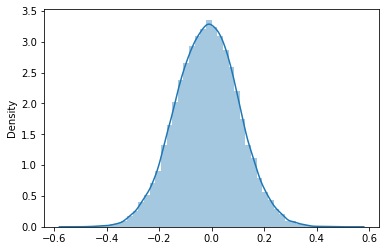

In [12]:
diffTime = trace.posterior['b'].data[:,:,3] - trace.posterior['b'].data[:,:,0]
sns.distplot(diffTime)
sum(diffTime.ravel()<0)/len(diffTime.ravel())

## Next we calculate the difference between the groups in each time
- Althgough the interaction wasn't significant, we still look at this one - as there's a group difference

In [13]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('hippo1 ~ groupIdx', df)
    traceSes1 = pm.sample(return_inferencedata=True)
az.summary(traceSes1, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept -0.031  0.083  -0.166    0.100      0.002    0.001    1983.0   
groupIdx   0.059  0.118  -0.132    0.253      0.003    0.002    1782.0   
sd         0.296  0.047   0.221    0.365      0.001    0.001    1926.0   

           ess_tail  r_hat  
Intercept    2157.0    1.0  
groupIdx     1989.0    1.0  
sd           1807.0    1.0

In [14]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('hippo2 ~ groupIdx', df)
    traceSes2 = pm.sample(return_inferencedata=True)
az.summary(traceSes2, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.184  0.149  -0.062    0.416      0.004    0.003    1640.0   
groupIdx  -0.294  0.205  -0.634    0.032      0.005    0.004    1686.0   
sd         0.494  0.080   0.368    0.619      0.002    0.001    2007.0   

           ess_tail  r_hat  
Intercept    1832.0    1.0  
groupIdx     1774.0    1.0  
sd           1658.0    1.0

In [15]:
with pm.Model() as model_glm:
    pm.GLM.from_formula('hippo3 ~ groupIdx', df)
    traceSes3 = pm.sample(return_inferencedata=True)
az.summary(traceSes3, hdi_prob=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, groupIdx, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  ess_bulk  \
Intercept  0.014  0.145  -0.217    0.250      0.004    0.003    1698.0   
groupIdx  -0.172  0.192  -0.486    0.132      0.005    0.003    1683.0   
sd         0.429  0.077   0.310    0.542      0.002    0.001    1790.0   

           ess_tail  r_hat  
Intercept    1908.0    1.0  
groupIdx     1895.0    1.0  
sd           1586.0    1.0

## Use a different way

In [16]:
## create a function that will simply run the model for each session
def runModel(variable):
    with pm.Model() as hierarchical:
      
        a = pm.Normal('a', mu=0, sd=1) 
        bMed = pm.Normal('bMed', mu=0, sd=1, shape=2) #

        # Model error
        eps = pm.HalfCauchy('eps', 5)

        y_hat = a + bMed[df.groupIdx]

        # Data likelihood
        likelihood = pm.Normal('likelihood', mu=y_hat,
                               sigma=eps, observed=df[str(variable)])

        trace = pm.sample(draws=4000, tune=1000,target_accept=0.9, return_inferencedata=False, cores=4)
        diff = trace['bMed'][:,1] - trace['bMed'][:,0]
    return trace, diff

In [17]:
ses1trace, ses1Diff = runModel('hippo1')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, bMed, a]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 23 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8370279330992273, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Group difference is 0.7030625


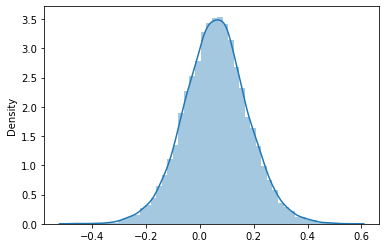

In [18]:
pm.summary(ses1trace)
sns.distplot(ses1Diff)
print(f'Group difference is {sum(ses1Diff>0)/len(ses1Diff)}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, bMed, a]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 20 seconds.


Group difference is 0.069125


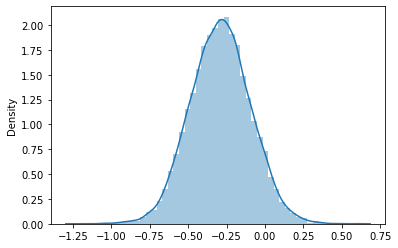

In [19]:
ses2trace, ses2Diff = runModel('hippo2')
pm.summary(ses2trace)
sns.distplot(ses2Diff)
print(f'Group difference is {sum(ses2Diff>0)/len(ses2Diff)}')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [likelihood_missing, eps, bMed, a]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 24 seconds.


Group difference is 0.1756875


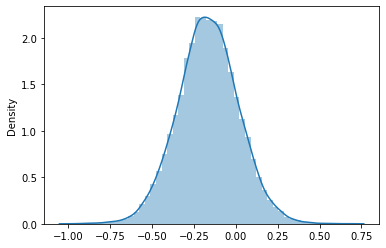

In [20]:
ses3trace, ses3Diff = runModel('hippo3')
pm.summary(ses3trace)
sns.distplot(ses3Diff)
print(f'Group difference is {sum(ses3Diff>0)/len(ses3Diff)}')

## Plotting

In [21]:
# set variables
def plotDiff(depVar,indepVar, trace):
    sns.set_style("ticks") # set style
    y = str(depVar)
    dfPlot = df
    ci = np.quantile(trace.posterior[str(indepVar)], [.05,.95])
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(3, 5),gridspec_kw={'width_ratios': [1, .2],
                                                            'wspace':.1})
    g1 = sns.stripplot(y= y, x='group', data=dfPlot, size = 8, ax=ax1)
    sns.boxplot(y= y, x='group', data=dfPlot,  ax=ax1,
                boxprops=dict(alpha=.3))
    g2 = sns.distplot(trace.posterior[str(indepVar)], ax = ax2, vertical=True)
    ax2.vlines(x=0.001,ymin=ci[0], ymax=ci[1], color='black', 
               linewidth = 3, linestyle = "-")

    #g3.set_ylim(-.7, .7)
    #ax1.set_ylim(-.7,.7)
    ax2.set_ylim(g1.get_ylim()) # use first graph's limits to get the relevant for this one
    ax2.yaxis.tick_right()
    ax2.set_xticks([])
    ax2.set_ylabel("Difference between groups", fontsize=14) 
    ax2.yaxis.set_label_position("right")
    ax1.set_ylabel("Hippocampus reactivity to traumatic script", fontsize=12)
    ax1.set_xlabel("Group", fontsize=14)
    fig.savefig( str(depVar) + 'Reactivity.png', dpi=300, bbox_inches='tight')
    return fig

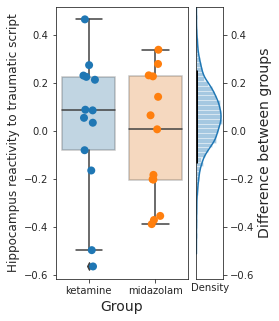

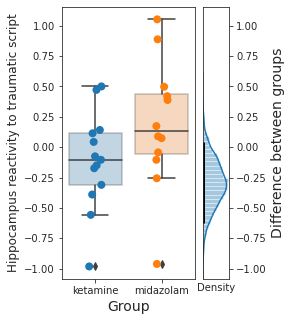

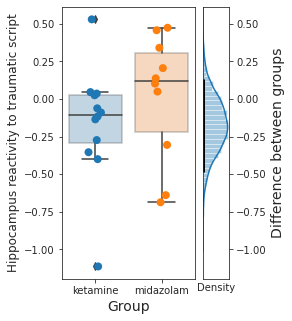

In [22]:
ax1 = plotDiff('hippo1','groupIdx',traceSes1)
ax2 = plotDiff('hippo2','groupIdx',traceSes2)
ax3 = plotDiff('hippo3','groupIdx',traceSes3)